In [ ]:
import time
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/sem5/gnr/

/content/drive/MyDrive/sem5/gnr


In [ ]:
from kervolution import *
from tools import *

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# classes = [str(x) for x in range(10)]

Files already downloaded and verified
Files already downloaded and verified


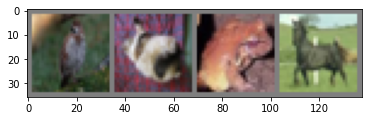

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),padding=0,stride=1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = (5,5),padding=0,stride=1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 30,kernel_size = (4,4),padding=0,stride=1)
        self.L1 = nn.Linear(120,84)
        self.L2 = nn.Linear(84,10)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.act = nn.Tanh()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.act(x)    
        x = x.view(x.size()[0], -1)
        x = self.L1(x)
        x = self.act(x)
        x = self.L2(x)
        return x

# net = LeNet().to(device)
# net.load_state_dict(torch.load(PATH))

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

net = ResNet18().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9, dampening=0.1)

In [ ]:
print(images.shape)

torch.Size([4, 3, 32, 32])


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print(f'Epoch: {epoch+1}, Time elapsed: {time.time() - start_time}')
print('Finished Training')

[1,  2000] loss: 2.128
[1,  4000] loss: 1.780
[1,  6000] loss: 1.568
[1,  8000] loss: 1.394
[1, 10000] loss: 1.261
[1, 12000] loss: 1.139
Epoch: 1, Time elapsed: 506.0226221084595
[2,  2000] loss: 1.037
[2,  4000] loss: 0.974
[2,  6000] loss: 0.886
[2,  8000] loss: 0.866
[2, 10000] loss: 0.836
[2, 12000] loss: 0.784
Epoch: 2, Time elapsed: 505.89905405044556
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = ResNet18()
net.load_state_dict(torch.load(PATH))
net = net.to(device)
images = images.to(device)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 73.4 %
Accuracy for class car   is: 90.2 %
Accuracy for class bird  is: 67.4 %
Accuracy for class cat   is: 65.7 %
Accuracy for class deer  is: 55.6 %
Accuracy for class dog   is: 58.2 %
Accuracy for class frog  is: 59.5 %
Accuracy for class horse is: 82.8 %
Accuracy for class ship  is: 87.4 %
Accuracy for class truck is: 81.8 %
